#Business Problem

<p align="justify"> perusahaan kartu kredit dapat mengenali transaksi kartu kredit palsu sehingga pelanggan tidak dikenakan biaya untuk barang yang tidak mereka beli.</p>

#Data Source

[dataset kaggle ](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

#Load Data

In [1]:
# connect to Kaggle API

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [2]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 96% 63.0M/66.0M [00:00<00:00, 136MB/s]
100% 66.0M/66.0M [00:00<00:00, 130MB/s]


In [4]:
!unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


#Import library

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier

# from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import StratifiedKFold
# from sklearn.pipeline import Pipeline


from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score


In [6]:
data = pd.read_csv('/content/creditcard.csv', sep=',')
data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
data.shape

(284807, 31)

In [11]:
# check imbalance dataset
data['Class'].value_counts(normalize=True)*100
print("Transaksi yang bukan Penipuan :", round(data['Class'].value_counts()[0]/len(data) * 100,2), '% dari dataset')
print("Transaksi Penipuan :" , round(data['Class'].value_counts()[1]/len(data) * 100,2), '% dari dataset')

Transaksi yang bukan Penipuan : 99.83 % dari dataset
Transaksi Penipuan : 0.17 % dari dataset


* **Catatan:** Pada dataset ini, sebagian besar transaksi adalah transaksi normal. Jika kami membangun model kami menggunakan kumpulan data ini, model kami mungkin tidak mendeteksi transaksi Penipuan. Untuk mengatasi masalah ketidakseimbangan dataset kita dapat menggunakan undersampling dengan teknik cross validation StratifiedKFold dan oversampling (SMOTE) dengan teknik cross validation StratifiedKFold.

#Exploratory Data Analysis

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 8,6
LABELS = ['Normal', 'Fraud']

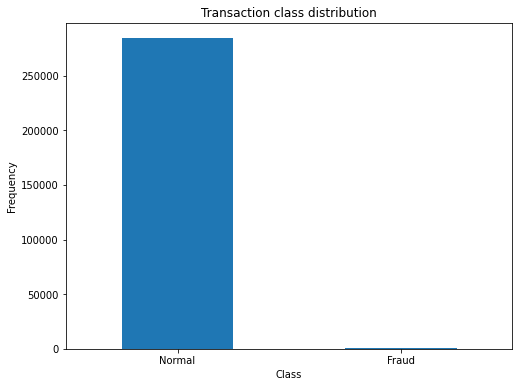

In [15]:
count_classes = pd.value_counts(data['Class'], sort=True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [16]:
# separating fraud and no-fraud transactions
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

print(fraud.shape, normal.shape)

(492, 31) (284315, 31)


In [20]:
#  descriptive statistics for normal transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [18]:
#  descriptive statistics for fraud transactions
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

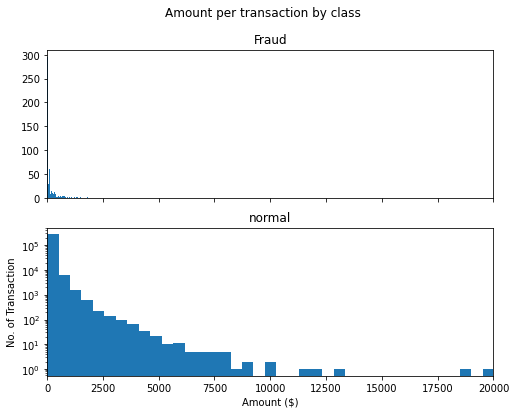

In [21]:
f, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f.suptitle("Amount per transaction by class")
bins = 50
ax1.hist(fraud.Amount, bins=bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins=bins)
ax2.set_title('normal')

plt.xlabel("Amount ($)")
plt.ylabel("No. of Transaction")

plt.xlim(0,20000)
plt.yscale('log')
plt.show()

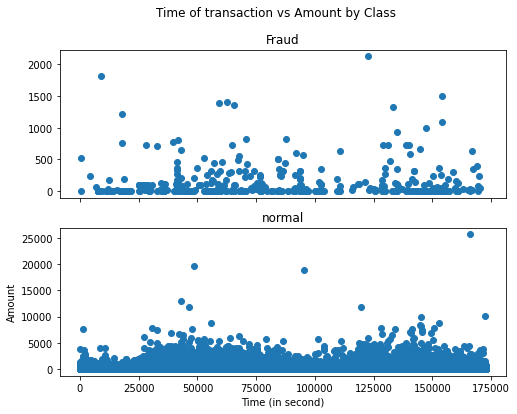

In [22]:
f, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f.suptitle("Time of transaction vs Amount by Class")

ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('normal')

plt.xlabel("Time (in second)")
plt.ylabel("Amount")

plt.show()

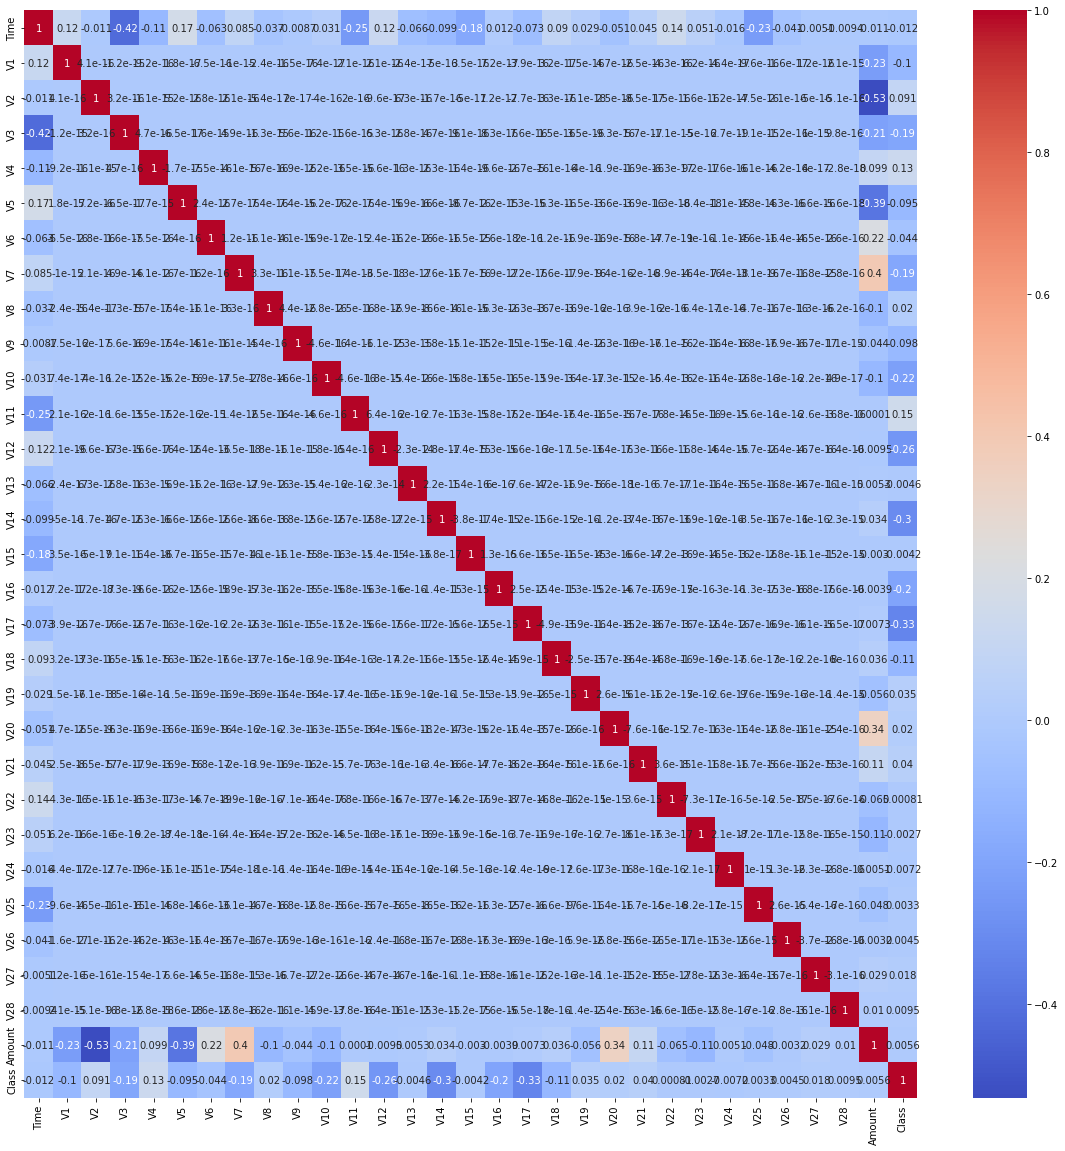

In [23]:
# Correlation check

corrmat = data.corr()
top_corr_feature = corrmat.index
plt.figure(figsize=(20,20))
g = sns.heatmap(data[top_corr_feature].corr(), annot=True, cmap='coolwarm')

In [25]:
# making a copy of original data
data1 = data.copy()
data1.shape

(284807, 31)

In [26]:
# feature scaling 'Amount' and 'Time'
standard_Scaler=StandardScaler()
data1['s_amount'] = standard_Scaler.fit_transform(data1['Amount'].values.reshape(-1,1))
data1['s_time'] = standard_Scaler.fit_transform(data1['Time'].values.reshape(-1,1))

data1.drop(['Time','Amount'], axis=1, inplace=True)


In [27]:
data1.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,s_amount,s_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [28]:
y=data1["Class"]
x= data1.drop(["Class"],axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, stratify=y, random_state=101)

In [30]:
#  Model training and evaluation
recall_list =[]
def modelEval(xtr,ytr,xte,yte,model):
    
    model.fit(xtr,ytr)
    
    # Prediction for Test and Train Dataset
    test_pred=model.predict(xte)
    train_pred =model.predict(xtr)
    
    tpr_score = metrics.precision_score(ytr, train_pred)
    trc_score = metrics.recall_score(ytr, train_pred)
    tac_score =metrics.accuracy_score(ytr,train_pred)

    #  Confusion Matrix and calculating accuracy score
    print("For Training Dataset.")   
    print(f'Accuracy: {tac_score:.4f}, Precision: {tpr_score:.2f}, Recall: {trc_score:.2f}')
    print(classification_report(ytr, train_pred))
    print("===============================")
    
    pr_score = metrics.precision_score(yte, test_pred)
    rc_score = metrics.recall_score(yte, test_pred)
    ac_score = metrics.accuracy_score(yte, test_pred)
    recall_list.append(rc_score)
    print("===============================")
    print("For Testing Dataset")
    print("===============================")
    print("F1:",metrics.f1_score(yte, test_pred))
    print(f'Accuracy: {ac_score:.2f}, Precision: {pr_score:.2f}, Recall: {rc_score:.2f}')
    print("===============================")
    

    print(classification_report(yte,test_pred))
    metrics.plot_confusion_matrix(model,xte,yte,cmap='YlGnBu')    


Model Name : RandomForest
For Training Dataset.
Accuracy: 0.9995, Precision: 0.95, Recall: 0.78
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170589
           1       0.95      0.78      0.86       295

    accuracy                           1.00    170884
   macro avg       0.98      0.89      0.93    170884
weighted avg       1.00      1.00      1.00    170884

For Testing Dataset
F1: 0.8374655647382919
Accuracy: 1.00, Precision: 0.92, Recall: 0.77
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113726
           1       0.92      0.77      0.84       197

    accuracy                           1.00    113923
   macro avg       0.96      0.89      0.92    113923
weighted avg       1.00      1.00      1.00    113923



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


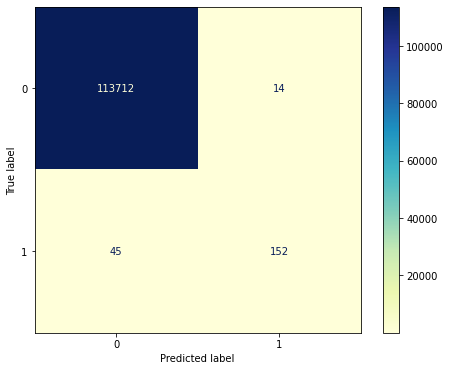

In [31]:
print("Model Name : RandomForest")

model_rf = RandomForestClassifier(n_estimators=200,criterion ='gini', max_depth=10, min_samples_leaf=10,
                                              min_samples_split=10, random_state=42)
rf_model_Acc = modelEval(X_train,y_train,X_test,y_test,model_rf)

For Training Dataset.
Accuracy: 0.9854, Precision: 0.10, Recall: 0.91
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    170589
           1       0.10      0.91      0.18       295

    accuracy                           0.99    170884
   macro avg       0.55      0.95      0.58    170884
weighted avg       1.00      0.99      0.99    170884

For Testing Dataset
F1: 0.1755081804660387
Accuracy: 0.99, Precision: 0.10, Recall: 0.90
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    113726
           1       0.10      0.90      0.18       197

    accuracy                           0.99    113923
   macro avg       0.55      0.94      0.58    113923
weighted avg       1.00      0.99      0.99    113923



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


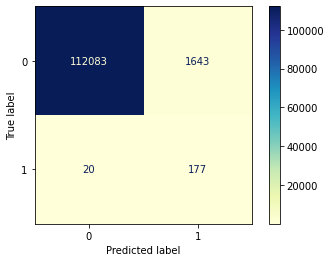

In [35]:
pipeline = imbpipeline(steps =[['underSample', RandomUnderSampler(random_state=110,sampling_strategy='majority')],
                           ['classifier', RandomForestClassifier(random_state=110)]])

RandomForestClassifier
param_grid = { "classifier__n_estimators":[200],
               "classifier__max_depth": [8,10],
               "classifier__min_samples_split":[10,12],
               "classifier__min_samples_leaf": [10,12],
               "classifier__criterion": ["gini", "entropy"]}

grid_search = GridSearchCV(estimator=pipeline,param_grid =param_grid,
                           
                           n_jobs=3)


rf_model_Acc = modelEval(X_train,y_train,X_test,y_test,grid_search)


For Training Dataset.
Accuracy: 0.9990, Precision: 0.63, Recall: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170589
           1       0.63      0.99      0.77       295

    accuracy                           1.00    170884
   macro avg       0.81      1.00      0.88    170884
weighted avg       1.00      1.00      1.00    170884

For Testing Dataset
F1: 0.655367231638418
Accuracy: 1.00, Precision: 0.52, Recall: 0.88
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113726
           1       0.52      0.88      0.66       197

    accuracy                           1.00    113923
   macro avg       0.76      0.94      0.83    113923
weighted avg       1.00      1.00      1.00    113923



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


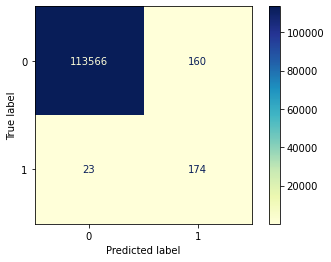

In [37]:
pipeline = imbpipeline(steps =[['smote', SMOTE(random_state=110)],
                           ['classifier', RandomForestClassifier(random_state=110)]])

RandomForestClassifier
param_grid = { "classifier__n_estimators":[150],
               "classifier__max_depth": [10],
               "classifier__min_samples_split":[12],
               "classifier__min_samples_leaf":[15],
               "classifier__criterion": ["gini"]}

grid_search = GridSearchCV(estimator=pipeline,param_grid =param_grid,
                           n_jobs=3)


rf_model_Acc = modelEval(X_train,y_train,X_test,y_test,grid_search)


For Training Dataset.
Accuracy: 0.9996, Precision: 0.95, Recall: 0.82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170589
           1       0.95      0.82      0.88       295

    accuracy                           1.00    170884
   macro avg       0.98      0.91      0.94    170884
weighted avg       1.00      1.00      1.00    170884

For Testing Dataset
F1: 0.8672086720867208
Accuracy: 1.00, Precision: 0.93, Recall: 0.81
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113726
           1       0.93      0.81      0.87       197

    accuracy                           1.00    113923
   macro avg       0.96      0.91      0.93    113923
weighted avg       1.00      1.00      1.00    113923



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


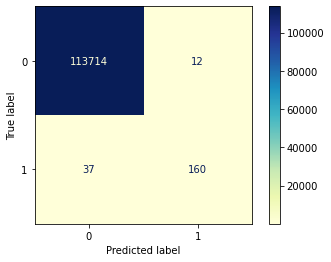

In [38]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()
xgb_model_Acc = modelEval(X_train,y_train,X_test,y_test,xgb_classifier)

In [39]:
model_list = ["Random Forest","RandomForestUnderSampler","RandomForestSMOTE","XGBoost"]


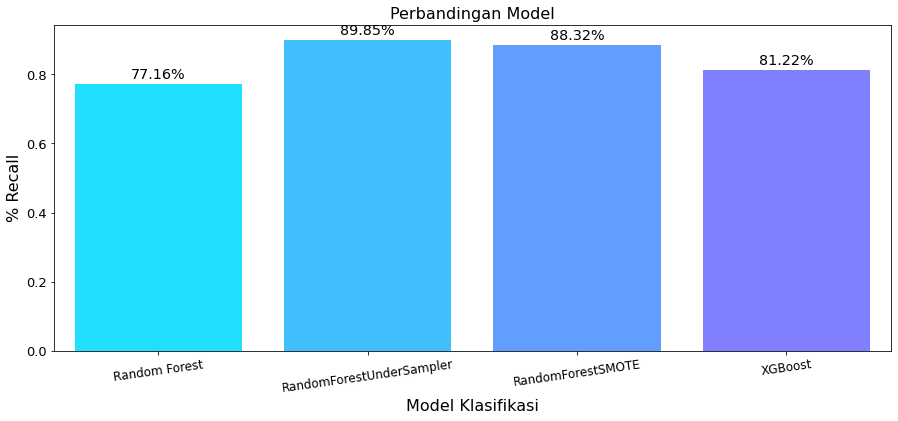

In [42]:
col_pal = sns.color_palette("cool",n_colors=7)
plt.rcParams['figure.figsize']=15,6 
ax = sns.barplot(x=model_list, y=recall_list, palette = col_pal, saturation =1.5)
plt.xlabel("Model Klasifikasi", fontsize = 16 )
plt.ylabel("% Recall", fontsize = 16)
plt.title("Perbandingan Model", fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()